# Hands-On Autoregressive & ARMA Models
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%201%20-%20Time%20Series/autoregressive-model.ipynb)

En este notebook se hará una simulación de un proceso auto-regresivo para el cual generaremos un conjungo de datos sintético. Posteriormente, conectaremos el modelo auto regresivo con el del promedio móvil para introducir el modelo ARMA o AutoRegressive Moving Average. 

En el caso de datos sintéticos, como nosotros controlamos la generación de estos datos, va a ser muy fácil determinar si el modelo que obtuvimos si se asemeja a lo que originalmente hemos modelado.

## Autoregressive Model
### Simulación de un AR(2)
Vamos a simular in proceso que obedece a los siguientes parámetros:
$$ y_t = 0.63y_{t-1} + 0.48y_{t-2}$$

In [1]:
import pkg_resources

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/requirements.txt  && pip install -r requirements.txt

Empezamos por generar la serie según los parámetros que hemos definido anteriormente.

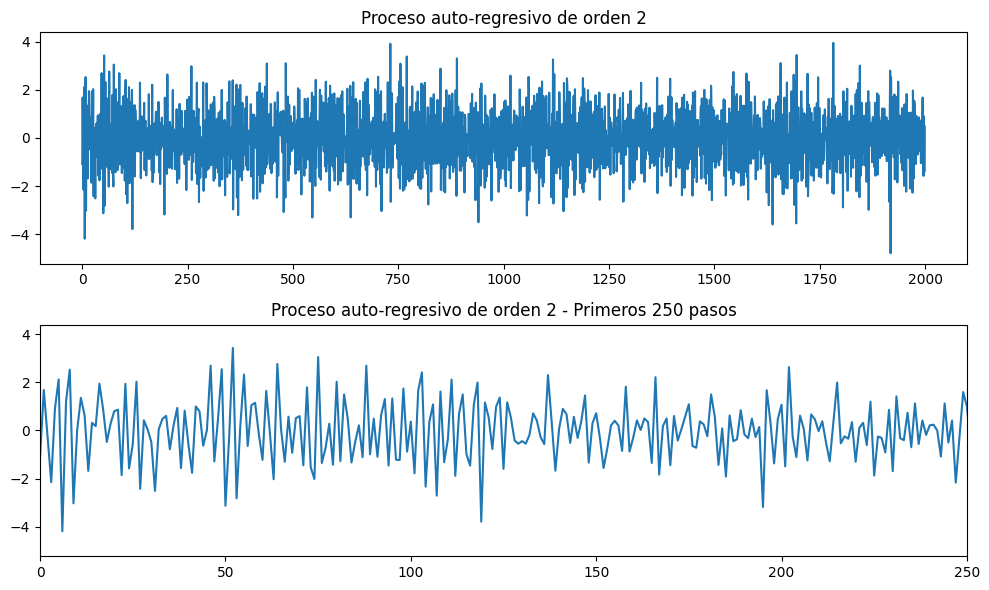

In [103]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import numpy as np

# Seed para resultados reproducibles
np.random.seed(123)

# Esta variable hace referencia al componente de promedio móvil, tal como vimos en el ejercicio anterior.
# por ahora, lo definimos sin coeficientes (salvo por la constante) para simular solamente la parte auto regresiva.
ma2 = np.array([1, 0, 0])

# El array arranca con 1 ya que este es el coeficiente de la constante no paramétrica
ar2 = np.array([1, 0.63, 0.48])

# generamos la serie según los parámetros que hemos definido
ar2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=2000)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ar2_process)
ax1.set_title("Proceso auto-regresivo de orden 2")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(ar2_process)
ax2.set_xlim(0, 250)
ax2.set_title("Proceso auto-regresivo de orden 2 - Primeros 250 pasos")

plt.tight_layout()
plt.show()

Fijemonos que hemos utilizado los mismos coeficientes que para el modelo MA anterior, pero esta vez para generar un proceso auto-regresivo. Además de eso, hemos usado el mismo seed para tener datos reproducibles. Observamos que las series son ciertamente diferentes.

Ahora observemos el gráfico ACF.

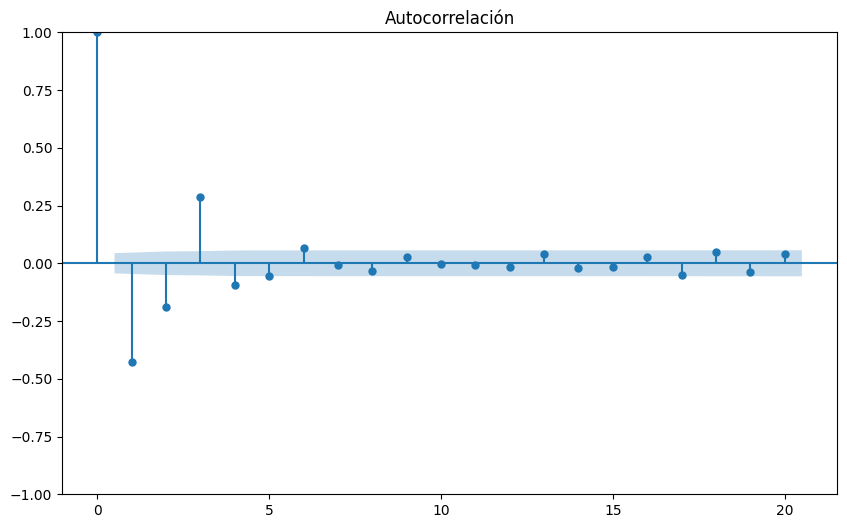

In [104]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plot_acf(ar2_process, lags=20, title="Autocorrelación", ax=ax)
plt.show()

Observamos un comportamiento oscilatorio y decreciente en los ordenes evaluados, lo cual nos impide establecer el orden del proceso y a su vez, nos sugiere que podría tratarse de un proceso auto regresivo. Observemos ahora el gráfico PACF.

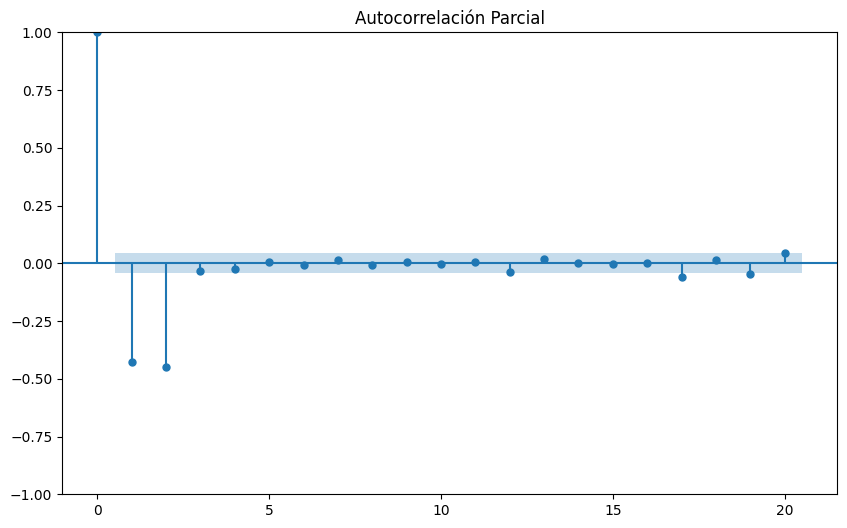

In [105]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plot_pacf(ar2_process, lags=20, title="Autocorrelación Parcial", ax=ax)
plt.show()

Aquí si obtenemos un resultado útil. Como es de esperarse, podemos comprobar que se trata de un proceso auto regresivo de orden 2.

Intentemos entrenar un modelo para recuperar los parámetros del proceso.

In [106]:
history = ar2_process[:-500]

# Nótese que a diverencia del ejemplo con MA, ahora especificamos el orden para la parte AR solamente.
ar_model = ARIMA(history, order=(2, 0, 0), enforce_stationarity=False).fit()

print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1500
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2085.999
Date:                Sun, 04 Feb 2024   AIC                           4179.998
Time:                        14:01:21   BIC                           4201.246
Sample:                             0   HQIC                          4187.914
                               - 1500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.012     -0.252      0.801      -0.027       0.021
ar.L1         -0.6147      0.024    -25.388      0.000      -0.662      -0.567
ar.L2         -0.4688      0.023    -19.965      0.0

Observamos que los parámetros `ar.L1 = -0.6147` y `ar.L2 = -0.4688` se acercan mucho a los originalmente definidos: $0.63$ y $0.48$ y su valor $p < 0.05$ lo cuals nos indica que estos parámetros explican el modelo con significancia estadística.

Sin embargo, obtuvimos parámetros negativos pero de igual magnitud! Esto puede deberse a multiples factores como la implementación del modelo, la forma en que se inicializan los parámetros o los ciclos de optimización que el modelo siguió. Como normal general lo que debe importar es la **magnitud** de los coeficientes obtenidos mas no su signo. En esta ocasión, sabemos de antemano que los coeficientes que usamos son positivos, por lo que es seguro invertir los resultados para obtener los coeficientes del modelo.

En otros escenarios, ante la duda, se puede intentar modelar con diferentes paquetes de software, los resultados deberían ser consistentes entre si, i.e., mismas magnitudes.

### Utilizando el modelo

In [107]:
forecast_size = 3
history = ar2_process[:-forecast_size]
test = ar2_process[-forecast_size:]
preds = []
for t in range(len(test)):
    model = ARIMA(history, order=(2, 0, 0), enforce_stationarity=False).fit()
    forecast = model.forecast(1)
    preds.append(forecast)
    history = np.append(history, forecast)

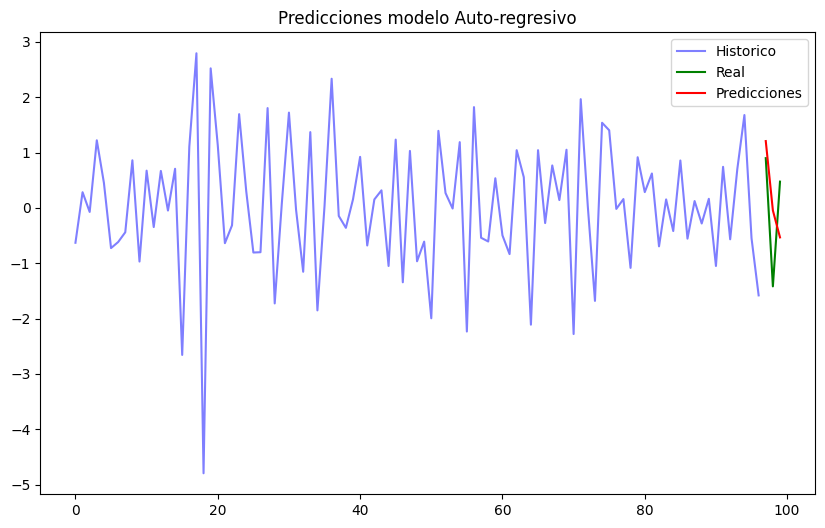

In [108]:
ground_truth = ar2_process[-100:-forecast_size]
forecast_range = np.arange(len(ground_truth), len(ground_truth) + forecast_size)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ground_truth, color='blue', alpha=0.5, label="Historico")
ax.plot(forecast_range, test, color='green', label="Real")
ax.plot(forecast_range, preds, color='red', label='Predicciones')
plt.title("Predicciones modelo Auto-regresivo")
plt.legend()
plt.show()

## Autoregressive Moving Average (ARMA)

Ahora vamos a generar un proceso que es tanto auto regresivo como de promedio móvil y observar sus ACF y PACF.

Para dar continuidad y consistencia con los ejemplos anteriores, vamos a generar un nuevo dataset sintético, combinando los modelos anteriormente vistos. Entonces:

Partiendo de:
$$
AR(2) = -0.63y_{t-1} + 0.48y_{t-2} \\
MA(2) = 0.63y_{t-1} + 0.48y_{t-2}
$$
Llegamos a:
$$
ARIMA(2, 0, 2) = [-0.63y_{t-1} + 0.48y_{t-2}] + [0.63y_{t-1} + 0.48y_{t-2}]
$$

Nótese que estámos usando los mismos parámetros que en los ejemplos vistos, esto es con el fin de ver que pasa cuando combinamos dos procesos distintos. Los coeficientes para cada proceso no tienen nada que ver entre si y en series de tiempo reales no tienen por que ser los mismos. Asimismo, el hecho de que estemos combinando dos procesos de orden 2, no quiere decir que siembre van a ser de orden 2 para ambos. Puede que nos encontremos con series que son $AR(p)$ y $MA(q)$, donde $p \ne q$.

**Nota:** Hemos definido el proceso ARMA como $ARIMA(2, 0, 2)$, esto es porque hay un tercer parámetro que representa la diferenciación y que completaría un modelo mayor que veremos en la siguiente lección. Para efectos de este ejemplo, hemos definido ese parámetro como $0$, que significa que no está presente.

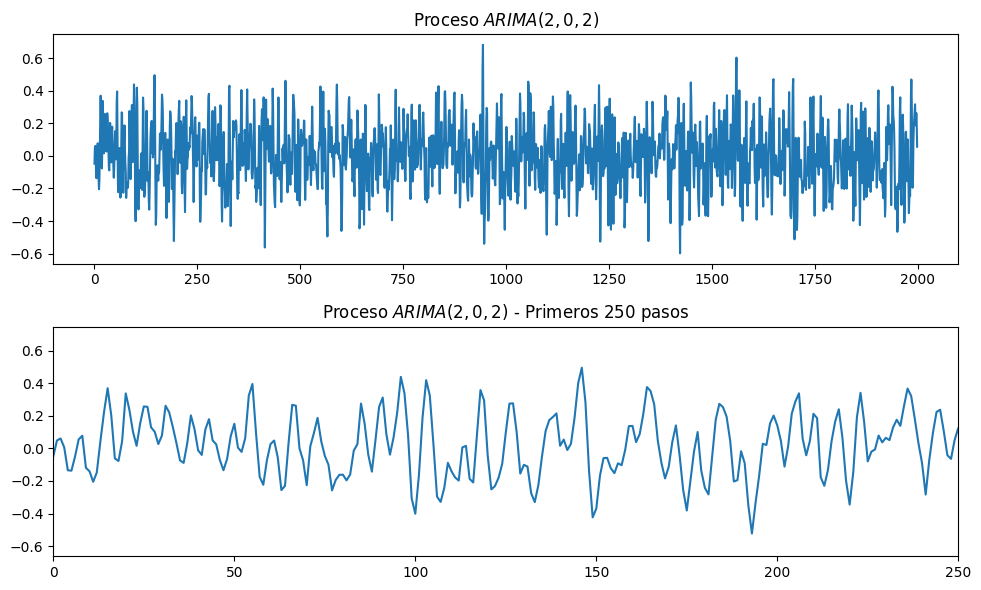

In [227]:
# Seguimos con el mismo seed

ar2 = np.array([1, -0.63, 0.48])
ma2 = np.array([1, 0.63, 0.48])

# generamos la serie según los parámetros que hemos definido
arma_process = ArmaProcess(ar2, ma2, nobs=2000)
arma2_process = arma_process.generate_sample(nsample=2000, scale=0.1)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(arma2_process)
ax1.set_title("Proceso $ARIMA(2, 0, 2)$")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(arma2_process)
ax2.set_xlim(0, 250)
ax2.set_title("Proceso $ARIMA(2, 0, 2)$ - Primeros 250 pasos")

plt.tight_layout()
plt.show()

Ahora, si observamos los gráficos ACF y PACF de este proceso, nos encontraremos con un problema.

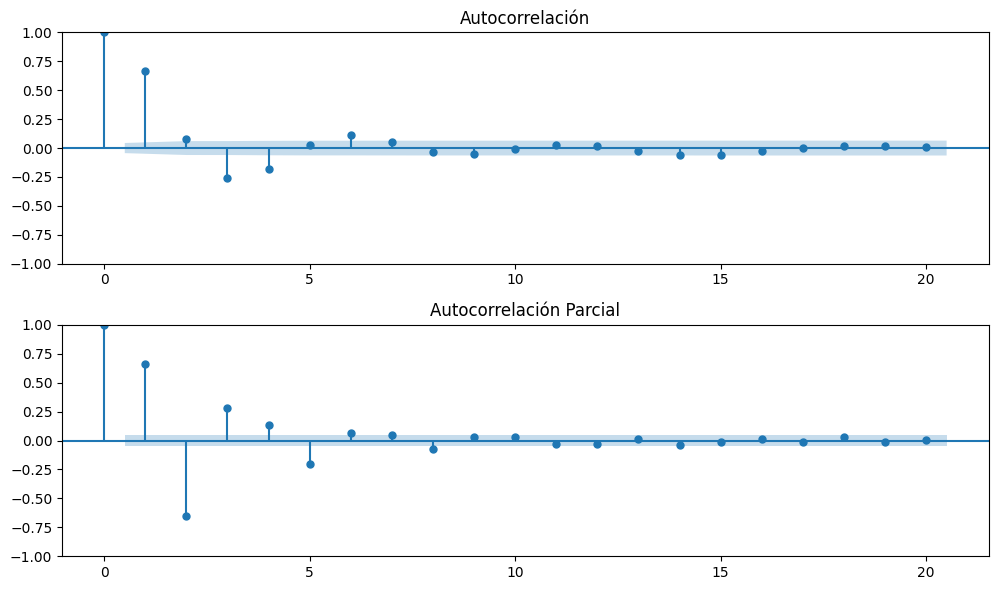

In [228]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(arma2_process, lags=20, title="Autocorrelación", ax=ax1)
plot_pacf(arma2_process, lags=20, title="Autocorrelación Parcial", ax=ax2)
plt.tight_layout()
plt.show()

No podemos sacar conclusiones respecto al orden de ninguno de los dos procesos!

Pero esto a su vez nos sugiere que la serie puede ser a su vez tanto auto regresiva como de promedio móvil. En la lección siguiente observaremos que se debe hacer en este caso.

Por ahora, como sabemos de antemano que la series es ARMA, entrenemos un modelo $ARIMA(2, 0, 2)$ para ver que pasa.

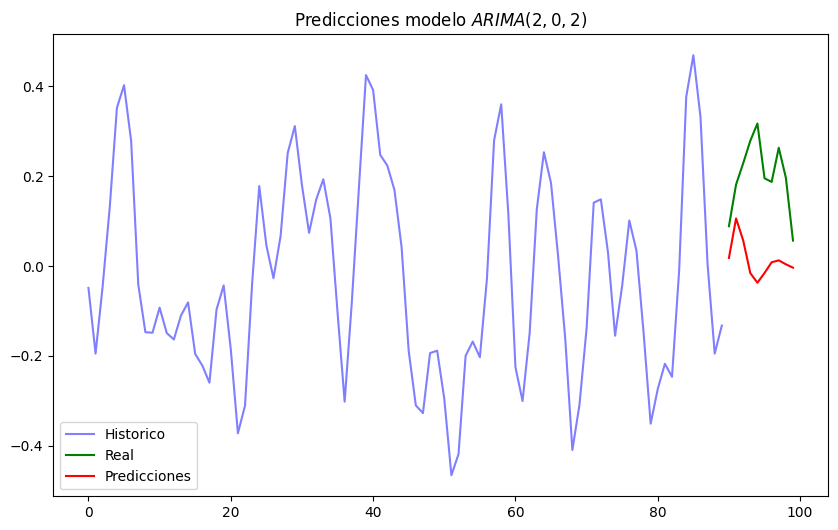

In [229]:
forecast_size = 10
history = arma2_process[:-forecast_size]
test = arma2_process[-forecast_size:]

# Especificamos el orden de los componentes
model = ARIMA(history, order=(2, 0, 2), trend='n', enforce_stationarity=True).fit()
preds = model.forecast(forecast_size)

ground_truth = arma2_process[-100:-forecast_size]
forecast_range = np.arange(len(ground_truth), len(ground_truth) + forecast_size)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ground_truth, color='blue', alpha=0.5, label="Historico")
ax.plot(forecast_range, test, color='green', label="Real")
ax.plot(forecast_range, preds, color='red', label='Predicciones')
plt.title("Predicciones modelo $ARIMA(2, 0, 2)$")
plt.legend()
plt.show()

In [230]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1990
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1774.933
Date:                Sun, 04 Feb 2024   AIC                          -3539.866
Time:                        15:19:01   BIC                          -3511.886
Sample:                             0   HQIC                         -3529.590
                               - 1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6197      0.032     19.635      0.000       0.558       0.682
ar.L2         -0.4817      0.027    -18.123      0.000      -0.534      -0.430
ma.L1          0.6598      0.031     21.255      0.000       0.599       0.721
ma.L2          0.5122      0.026     19.506      0.000       0.461       0.564
sigma2         0.0098      0.000     29.071      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 7.42
Prob(Q):                              0.84   Prob(JB):                         0.02
Heteroskedasticity (H):               0.97   Skew:                            -0.01
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Algunos detalles para analizar:

1. Las predicciones comienzan a ser más "realistas", están en el mismo rango de la serie y no distan demasiado de los valores reales de la serie.
2. Los parámetros/coeficientes obtenidos nuevamente se asemejan en *magnitud* a los definidos en el proceso.
3. Cuando definimos la generación del proceso, utilizamos signos diferentes para los coeficientes del componente auto-regresivo, esto fue para generar una serie más estable. Los valores absolutos del componente auto regresivo deberían ser inferiores a 1, si ambos fueran positivos, podríamos terminar con un componente que crece un crecimiento explosivo, haciendo a la serie muy inestable y por consiguente, dificil de entrenar modelos precisos para esta.

En la siguiente lección veremos el componente final, la diferenciación.